# Random forest decision making statistics
After training a random forest classifier, we can study its internal mechanics. APOC allows to retrieve the number of decisions in the forest based on the given features.

In [1]:
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import pandas as pd
import numpy as np
import apoc
import matplotlib.pyplot as plt
import pandas as pd

cle.select_device('RTX')

<Apple M1 Max on Platform: Apple (2 refs)>

For demonstration purposes we use an image from David Legland shared under [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) available  the [mathematical_morphology_with_MorphoLibJ](https://github.com/dlegland/mathematical_morphology_with_MorphoLibJ/blob/master/sampleImages/maize_clsm.tif) repository. 

We also add a label image that was generated in an earlier chapter.

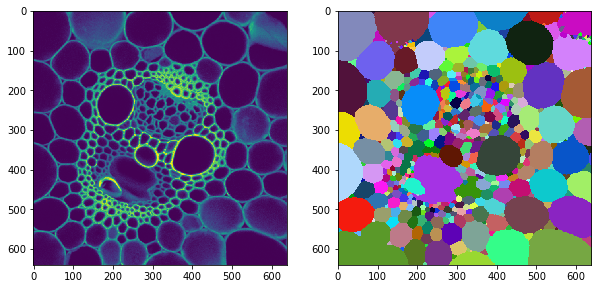

In [2]:
image = cle.push(imread('../../data/maize_clsm.tif'))
labels = cle.push(imread('../../data/maize_clsm_labels.tif'))

fix, axs = plt.subplots(1,2, figsize=(10,10))
cle.imshow(image, plot=axs[0])
cle.imshow(labels, plot=axs[1], labels=True)

We previously created an object classifier and apply it now to the pair of intensity and label images.

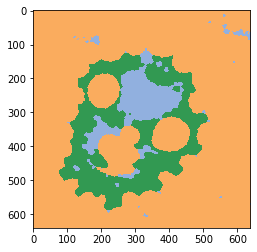

In [3]:
classifier = apoc.ObjectClassifier("../../data/maize_cslm_object_classifier.cl")
classification_map = classifier.predict(labels=labels, image=image)

cle.imshow(classification_map, labels=True, min_display_intensity=0)

## Classifier statistics
The loaded classifier can give us statistical information about its inner structure. The random forest classifier consists of many decision trees and every decision tree consists of binary decisions on multiple levels. E.g. a forest with 10 trees makes 10 decisions on the first level, as every tree makes at least this one decision. On the second level, every tree can make up to 2 decisions, which results in maximum 20 decisions on this level. We can now visualize how many decisions on every level take specific features into account. The statistics are given as two dictionaries which can be visualized using [pandas](https://pandas.pydata.org/)

In [4]:
shares, counts = classifier.statistics()

First, we display the number of decisions on every level. Again, from lower to higher levels, the total number of decisions increases, in this table from the left to the right.

In [5]:
pd.DataFrame(counts).T

,0,1,2
area,1,13,30
mean_intensity,23,15,38
standard_deviation_intensity,26,30,40
mean_max_distance_to_centroid_ratio,2,23,28
touching_neighbor_count,0,17,24
average_distance_of_touching_neighbors,10,14,38
average_distance_of_n_nearest_neighbors=1,12,29,24
average_distance_of_n_nearest_neighbors=6,14,21,26
average_distance_of_n_nearest_neighbors=10,12,29,41


The table above tells us that on the first level, 26 trees took `mean_intensity` into account, which is the highest number on this level. On the second level, 30 decisions were made taking the `standard_deviation_intensity` into account. The average distance of n-nearest neighbors was taken into account 21-29 times on this level, which is close. You could argue that intensity and centroid distances between neighbors were the crucial parameters for differentiating objects.

Next, we look at the normalized `shares`, which are the counts divided by the total number of decisions made per depth level. We visualize this in colour to highlight features with high and low values.

In [6]:
def colorize(styler):
    styler.background_gradient(axis=None, cmap="rainbow")
    return styler

df = pd.DataFrame(shares).T
df.style.pipe(colorize)

,0,1,2
area,0.010000,0.068063,0.103806
mean_intensity,0.230000,0.078534,0.131488
standard_deviation_intensity,0.260000,0.157068,0.138408
mean_max_distance_to_centroid_ratio,0.020000,0.120419,0.096886
touching_neighbor_count,0.000000,0.089005,0.083045
average_distance_of_touching_neighbors,0.100000,0.073298,0.131488
average_distance_of_n_nearest_neighbors=1,0.120000,0.151832,0.083045
average_distance_of_n_nearest_neighbors=6,0.140000,0.109948,0.089965
average_distance_of_n_nearest_neighbors=10,0.120000,0.151832,0.141869


Adding to our insights described above, we can also see here that the distribution of decisions on the levels becomes more uniform the higher the level. Hence, one could consider training a classifier with maybe just two depth levels.